In [1]:
#### ---- Self-adaptive weighted filter to remove GAUSSIAN & IMPULSIVE noise in INFRARED images ---- ####

## for grayscale images

In [2]:
import numpy as np
import cv2
from scipy import signal
from skimage import io, color
from matplotlib import pyplot as plt
import math
from skimage.filters import sobel

window_size = 3
W = window_size//2
poz_median=window_size*window_size//2

In [3]:
#####################################################
#####################################################
# functii: 
#   -> MSE 
#   -> PSNR 
#   -> add gaussian/impulsive noise 
#   -> bordare imagine
#   -> compute thresholds
#   -> compute_image_detail_metrics
#   -> compute_thresholds_alt_variant
#####################################################
#####################################################

def mse(img, img_modif, capat):
    h,w = img.shape
    delta = img[capat:h-capat,capat:w-capat] - img_modif[capat:h-capat,capat:w-capat]
    delta = delta ** 2
    return np.sum(delta) / ((h-capat*2)*(w-capat*2))

def psnr(img, img_modif, capat):
    mseval = mse(img, img_modif, capat)
    return 20 * math.log10(255) - 10 * math.log10(mseval)

#####################################################

def add_gaussian_noise(img_gray,disp):
    # parametrii : imaginea originala, dispersia zgomotului
    h,w = np.shape(img_gray)
    noise = np.random.normal(0,disp,(h,w))
    img_noise = img_gray + noise
    # intoarce imaginea cu zgomot
    return img_noise

# SNR = signal to noise ration
# 1 - 0 zgomot
# 0 - 100% zgomot
# 0.95 - 5% zgomot
# 0.91 - 9% zgomot
def add_impulsive_noise(img, SNR):
    img_n = img.copy()
    h,w = img.shape
    noise_mask = np.random.choice((0,1,2), size=(h,w), p=[SNR, (1 - SNR) / 2., (1 - SNR) / 2.])
    img_n[noise_mask == 1] = 255
    img_n[noise_mask == 2] = 0
    return img_n

#####################################################

def bordare_imagine(image, window_size = 3):
    
    [L,C]=np.shape(image)
    kernel=np.zeros((window_size,window_size))
    kernel[W,W]=1
    Ybordat=np.zeros((L+window_size-1,C+window_size-1))
    Ybordat[:,:] = signal.convolve2d(image[:,:], kernel, mode='full', boundary='symm')

    return Ybordat

#####################################################

def compute_thresholds(image):
    """
    Compute thresholds based on image details.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        tuple: A tuple containing two thresholds (threshold1, threshold2).
    """
    if image is None:
        raise ValueError("Image not found or invalid image format.")

    # Calculate edge density using Canny edge detection
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size

    # Calculate variance of pixel intensity
    intensity_variance = np.var(image)

    # Normalize metrics to a range of 0 to 1
    normalized_edge_density = min(1, edge_density / 0.1)  # Assume 0.1 is high edge density
    normalized_intensity_variance = min(1, intensity_variance / 5000)  # Adjust 5000 based on experimentation

    # Combine metrics to estimate image details (weights can be adjusted)
    detail_level = 0.7 * normalized_edge_density + 0.3 * normalized_intensity_variance

    # Scale thresholds based on detail level
    threshold1 = 40 + detail_level * (90 - 40)
    threshold2 = 1 + detail_level * (8 - 1)

    return round(threshold1), round(threshold2)

#####################################################

def compute_image_detail_metrics(image):
    """
    Compute metrics for evaluating image detail.

    Parameters:
        image (numpy.ndarray): Grayscale image array.

    Returns:
        tuple: Edge density, intensity variance, entropy, gradient mean.
    """
    # Edge Density
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size

    # Intensity Variance
    intensity_variance = np.var(image)

    # Entropy
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256], density=True)
    entropy = -np.sum(histogram * np.log2(histogram + 1e-9))

    # Gradient Magnitude (using Sobel filter)
    gradient = sobel(image)
    gradient_mean = np.mean(gradient)

    return edge_density, intensity_variance, entropy, gradient_mean

def compute_thresholds_alt_variant(image):
    """
    Compute thresholds based on image details.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        tuple: A tuple containing two thresholds (threshold1, threshold2).
    """

    if image is None:
        raise ValueError("Image not found or invalid image format.")

    # Compute image detail metrics
    edge_density, intensity_variance, entropy, gradient_mean = compute_image_detail_metrics(image)

    # Normalize metrics to a range of 0 to 1
    normalized_edge_density = min(1, edge_density / 0.1)  # Assume 0.1 is high edge density
    normalized_intensity_variance = min(1, intensity_variance / 5000)  # Adjust 5000 based on experimentation
    normalized_entropy = min(1, entropy / 8)  # Assume max entropy is around 8
    normalized_gradient = min(1, gradient_mean / 0.5)  # Assume 0.5 is high gradient mean

    # Combine metrics to estimate detail level (weights can be adjusted)
    detail_level = (0.3 * normalized_edge_density +
                    0.3 * normalized_intensity_variance +
                    0.2 * normalized_entropy +
                    0.2 * normalized_gradient)

    # Scale thresholds based on detail level
    threshold1 = 40 + detail_level * (90 - 40)
    threshold2 = 0 + detail_level * (8 - 0)

    return round(threshold1), round(threshold2)

#####################################################

def afisare_metrici(img_zg, img_filtrata, gaussian_counter, impulsive_counter, normal_counter):

    [L,C] = np.shape(img_zg)
    print("Results:\nGaussian points: {0}\nImpulsive points: {1}\nNormal points: {2}".format(gaussian_counter, impulsive_counter, normal_counter))
    print("\nGaussian noise: {0}%\nImpulsive noise: {1}%".format(round(gaussian_counter/(L*C)*100,2), round(impulsive_counter/(L*C)*100,2)))
    print("MSE pentru imaginea filtrata pixel cu pixel (la misto): {0}".format(mse(img_zg, img_filtrata, W)))
    print("PSNR pentru imaginea filtrata normal (la misto): {0}".format(psnr(img_zg, img_filtrata, W)))


In [4]:
## calculate thresholds
img = io.imread('Thermogram-infrared-image-Image-of-a-hand-taken-in-mid-infrared-thermal-light (1).png')
if len(np.shape(img)) > 2:
    print("original image not grayscale \nsize was {0}".format(np.shape(img)))
    img=np.uint8(color.rgb2gray(img[:,:,:3])*255)
else:
    img = img
    print(np.shape(img))
    
T1, T2 = compute_thresholds(img)
print(T1, T2)

T3, T4 = compute_thresholds_alt_variant(img)
print(T3, T4)

original image not grayscale 
size was (528, 710, 4)
57 3
64 4


In [5]:
#####################################################
## function to calculate weights in (3x3) window

def calculate_weights(flattened_window, diff):
    """Calculate adaptive weights for a filter window."""

    differences = np.abs(flattened_window - diff)
    weights = 1/(1+differences**2)
    normalized_weights = weights/np.sum(weights)

    return normalized_weights

#####################################################

flattened_window = np.array([8, 2, 10, 4, 6, 9])
diff = 7

print(calculate_weights(flattened_window, diff))


[0.34759358 0.02673797 0.06951872 0.06951872 0.34759358 0.13903743]


In [6]:
#####################################################

def self_adaptive_gaussian_filter(img, window_size):
    """Apply the self-adaptive weighted mean filter for every channel, RGB."""

    # if (np.max(img)>1):
    #     img = img/255.0
    [L,C]=np.shape(img)

    Ybordat = bordare_imagine(img, window_size)

    imgout = np.zeros((L,C))
    for l in range(0,L):
        for c in range(0,C):
            # selecteaza valori conform ferestrei plasate in pozitia (l,c)
            val_selectate = Ybordat[l-W+W:l+W+1+W,c-W+W:c+W+1+W] # shiftez cu W

            # calculare medie si weights
            mean = np.mean(val_selectate)
            weights = calculate_weights(val_selectate, mean)
            
            # scrie rezultatul in imgout[l,c]
            imgout[l,c] = np.sum(weights*val_selectate[:,:])

    return imgout

#####################################################

def self_adaptive_impusive_filter(img, window_size = 3):
    """Apply the self-adaptive weighted median filter."""
    if (np.max(img)>1):
        img = img/255.0
    [L,C]=np.shape(img)

    Ybordat = bordare_imagine(img, window_size)

    imgout = np.zeros((L,C))
    for l in range(0,L):
        for c in range(0,C):
            # selecteaza valori conform ferestrei plasate in pozitia (l,c)
            val_selectate = Ybordat[l-W+W:l+W+1+W,c-W+W:c+W+1+W] # shiftez cu W

            # sortam valorile, eliminam prima si ultima valoare & calculam weights
            val_sortate = np.sort(val_selectate)
            val_sortate = val_sortate[1:len(val_sortate)-1]
            
            middle_val = val_sortate[len(val_sortate)//2]
            weights = calculate_weights(val_sortate, middle_val)
            
            # scrie rezultatul in imgout[l,c]
            imgout[l,c] = np.sum(weights*val_selectate[:,:])

    return imgout

#####################################################

In [7]:
#####################################################
### Window filter functions for grayscale images ###
#####################################################

def gaussian_filter_in_window_gray(window):
    # 3x3 window
    mean = np.mean(window)
    weights = calculate_weights(window, mean)

    centered_pixel = np.sum(weights*window[:,:])  

    return centered_pixel  

#####################################################

def impulsive_filter_in_window_gray(window):
    # 3x3 window
    val_sortate = np.sort(window)
    val_sortate = val_sortate[1:len(val_sortate)-1]

    middle_val = val_sortate[len(val_sortate)//2]
    weights = calculate_weights(val_sortate, middle_val)
    
    centered_pixel = np.sum(weights*window[1:len(window)-1]) 

    return centered_pixel

#####################################################

original image not grayscale 
size was (528, 710, 4)


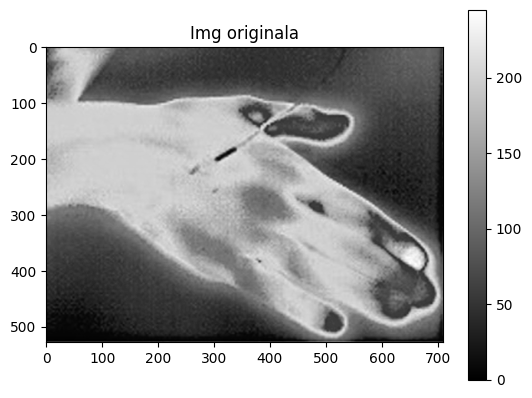

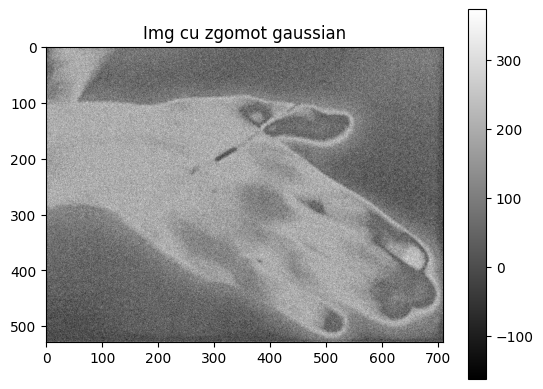

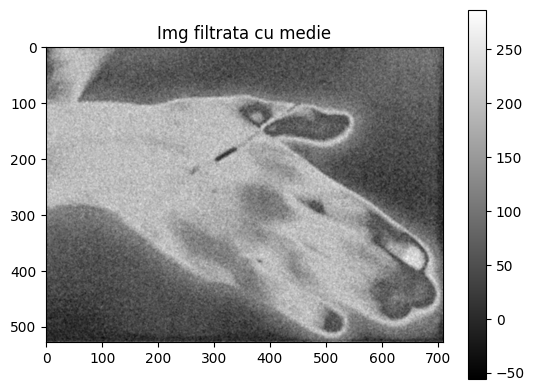

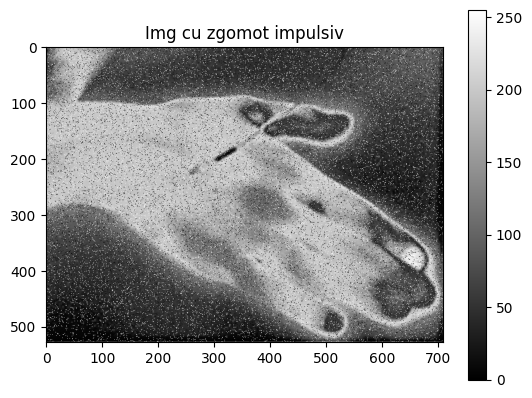

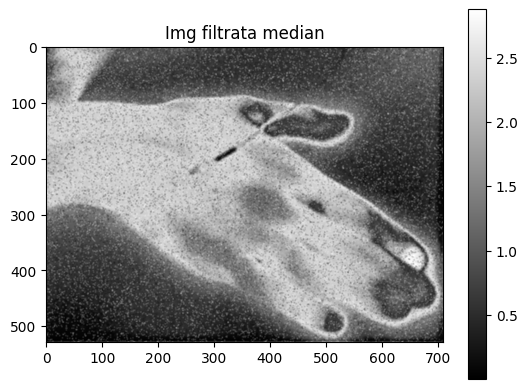

(<Figure size 640x480 with 2 Axes>,
 Text(0.5, 1.0, 'Img filtrata median'),
 None)

In [8]:
#####################################################
# Example usage with self_adaptive_filter functions
#####################################################

# Load grayscale image
# img = cv2.imread('infrared-768x513.jpg', cv2.IMREAD_GRAYSCALE)
img = io.imread('Thermogram-infrared-image-Image-of-a-hand-taken-in-mid-infrared-thermal-light (1).png')
if len(np.shape(img)) > 2:
    print("original image not grayscale \nsize was {0}".format(np.shape(img)))
    img=np.uint8(color.rgb2gray(img[:,:,:3])*255)
else:
    img = img
    print(np.shape(img))

plt.figure(), plt.title("Img originala"), plt.imshow(img, cmap='gray'),plt.colorbar(),plt.show()

# add gaussian noise
img_noise_gauss = add_gaussian_noise(img, 40)
plt.figure(), plt.title("Img cu zgomot gaussian"), plt.imshow(img_noise_gauss, cmap='gray'),plt.colorbar(),plt.show()

# Apply the self-adaptive weighted gaussian filter
filtered_image_gauss = self_adaptive_gaussian_filter(img_noise_gauss, 3)
plt.figure(),plt.title("Img filtrata cu medie") , plt.imshow(filtered_image_gauss, cmap='gray'),plt.colorbar(),plt.show()

#####################################################
#####################################################

# add impulsive noise
img_noise_impulsive = add_impulsive_noise(img, 0.91)
plt.figure(),plt.title("Img cu zgomot impulsiv") , plt.imshow(img_noise_impulsive, cmap='gray'),plt.colorbar(),plt.show()

# Apply the self-adaptive weighted impulsive filter
filtered_image_impulsive = self_adaptive_impusive_filter(img_noise_impulsive, 3)
plt.figure(),plt.title("Img filtrata median") , plt.imshow(filtered_image_impulsive, cmap='gray'),plt.colorbar(),plt.show()


In [9]:
###################################################################
## function to detect noise pixel (gaussian /impulsive) and apply
## corresponding filter (s_w_median / s_w_mean) 
## returns imgout, gaussian/impulsive/pixel counters in imgout 
###################################################################

def compute_image_with_noise(img_noise, window_size, T1, T2):
    gaussian_counter = 0
    impulsive_counter = 0
    normal_counter = 0
    [L,C]=np.shape(img_noise)

    Ybordat = bordare_imagine(img_noise, window_size) 

    imgout = np.zeros((L,C))
    for l in range(0,L):
        for c in range(0,C):
            # extract window and center pixel
            val_selectate = Ybordat[l-W+W:l+W+1+W,c-W+W:c+W+1+W] # shiftez cu W
            l1,c1 = np.shape(val_selectate)
            centered_pixel = val_selectate[l1//2, c1//2]

            # calcualate differences between center and the rest of pixels from window
            differences = np.abs(val_selectate - centered_pixel)

            # Count neighbors with differences greater than T1
            N = np.sum(differences > T1)
            
            # Classify noise and filter accordingly
            if N == 0:
                imgout[l,c] = gaussian_filter_in_window_gray(val_selectate) # gaussian - mean filter
                # print("gauss: col {0}, linia {1}".format(l,c))
                gaussian_counter+=1
            elif N > T2:
                imgout[l,c] = impulsive_filter_in_window_gray(val_selectate) # impulsive - median filter
                # print("impulsive: col {0}, linia {1}".format(l,c))
                impulsive_counter+=1
            else: 
                imgout[l,c] = centered_pixel
                # print("normal: col {0}, linia {1}".format(l,c))
                normal_counter+=1

    return imgout, gaussian_counter, impulsive_counter, normal_counter

original image not grayscale 
size was (513, 768, 3)


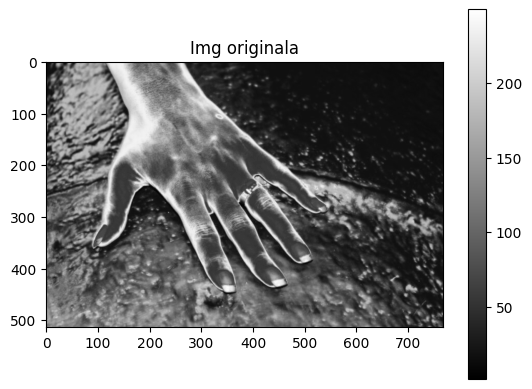

(<Figure size 640x480 with 2 Axes>,
 Text(0.5, 1.0, 'Img originala'),
 None)

In [10]:
img = io.imread('infrared-768x513.jpg')

if len(np.shape(img)) > 2:
    print("original image not grayscale \nsize was {0}".format(np.shape(img)))
    img=np.uint8(color.rgb2gray(img[:,:,:3])*255)
else:
    img = img
    print(np.shape(img))

plt.figure(), plt.title("Img originala"), plt.imshow(img, cmap='gray'),plt.colorbar(),plt.show()

original image not grayscale 
size was (528, 710, 4)


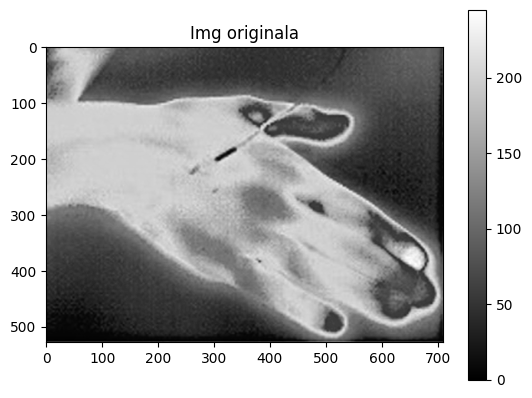

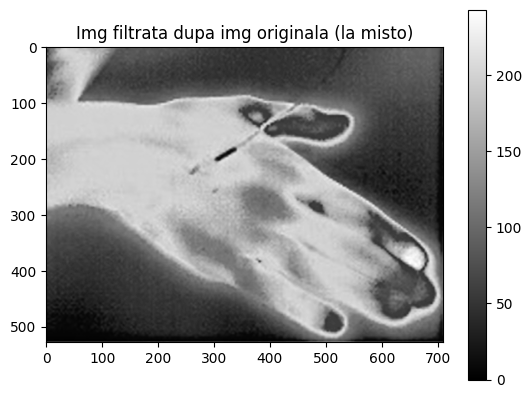

Results:
Gaussian points: 356659
Impulsive points: 1822
Normal points: 16399

Gaussian noise: 95.14%
Impulsive noise: 0.49%
MSE pentru imaginea filtrata pixel cu pixel (la misto): 0.8909440398781263
PSNR pentru imaginea filtrata normal (la misto): 48.632299339750986


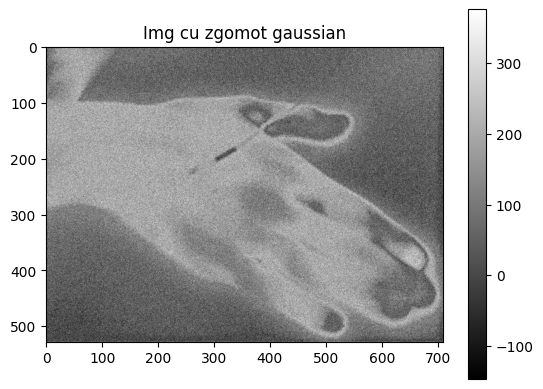

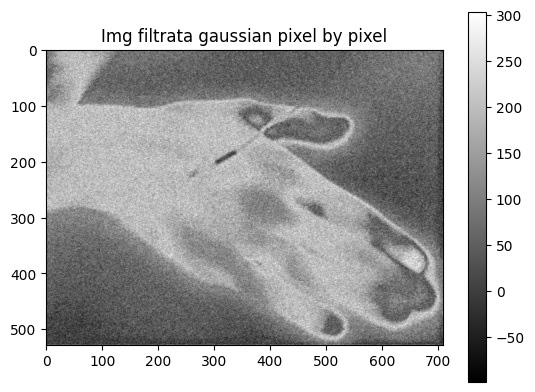

Results:
Gaussian points: 42904
Impulsive points: 98052
Normal points: 233924

Gaussian noise: 11.44%
Impulsive noise: 26.16%
MSE pentru imaginea filtrata pixel cu pixel (la misto): 650.5531502696728
PSNR pentru imaginea filtrata normal (la misto): 19.997975766100154


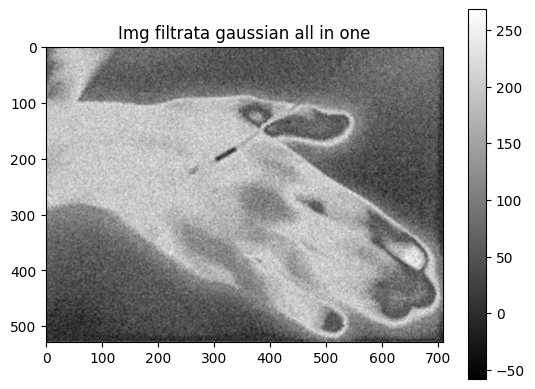

MSE pentru imaginea filtrata normal: 194.84468235041086
PSNR pentru imaginea filtrata normal: 25.23391803227716

#
#
#
#
#
#


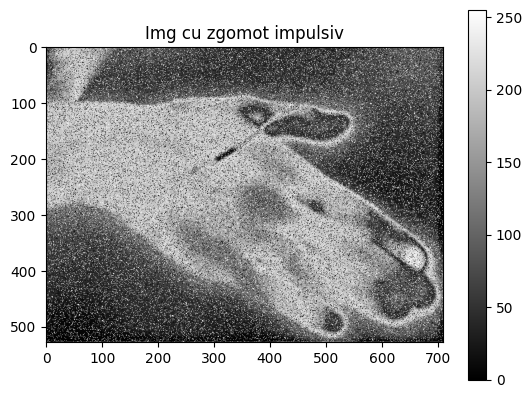

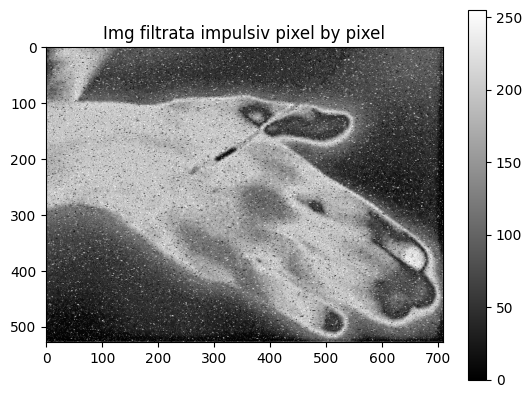

Results:
Gaussian points: 86642
Impulsive points: 71337
Normal points: 216901

Gaussian noise: 23.11%
Impulsive noise: 19.03%
MSE pentru imaginea filtrata pixel cu pixel (la misto): 2407.6359924719072
PSNR pentru imaginea filtrata normal (la misto): 14.314895337682813


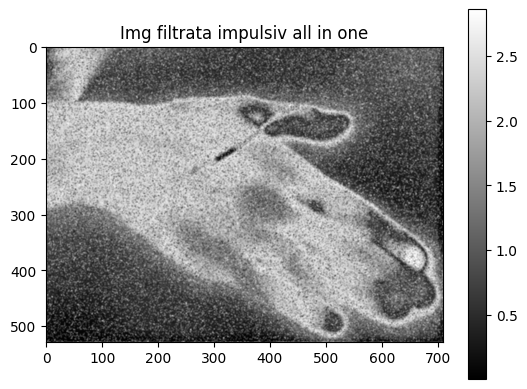

MSE pentru imaginea filtrata normal: 17343.2963866563
PSNR pentru imaginea filtrata normal: 5.739487148744146


In [ ]:
###################################################################
##### Here example of usage using gaussian and impulsive filter regarding every pixel (with window functions)
###################################################################
# TODO incearca sa faci o copie dupa img initiala si daca pixelul != img initiala => zgomot altfel nu schimbam val pixelului

img = io.imread('Thermogram-infrared-image-Image-of-a-hand-taken-in-mid-infrared-thermal-light (1).png')
L,C,pl = np.shape(img)

if pl > 2:
    print("original image not grayscale \nsize was {0}".format(np.shape(img)))
    img=np.uint8(color.rgb2gray(img[:,:,:3])*255)
else:
    img = img
    print(np.shape(img))

T1 = 18
T2 = 5
plt.figure(), plt.title("Img originala"), plt.imshow(img, cmap='gray'),plt.colorbar(),plt.show()

[L,C]=np.shape(img)
[imgout, gaussian_counter, impulsive_counter, normal_counter] = compute_image_with_noise(img, 3, T1, T2)
plt.figure(), plt.title("Img filtrata dupa img originala (la misto)"), plt.imshow(imgout, cmap='gray'), plt.colorbar(), plt.show()
afisare_metrici(img, imgout, gaussian_counter, impulsive_counter, normal_counter)

T1, T2 = compute_thresholds(img)
# add gaussian noise
img_noise_gauss = add_gaussian_noise(img, 40)
plt.figure(), plt.title("Img cu zgomot gaussian"), plt.imshow(img_noise_gauss, cmap='gray'),plt.colorbar(),plt.show()

# filter with pixel by pixel function
[imgout, gaussian_counter, impulsive_counter, normal_counter] = compute_image_with_noise(img_noise_gauss, 3, T1, T2)

plt.figure(), plt.title("Img filtrata gaussian pixel by pixel"), plt.imshow(imgout, cmap='gray'),plt.colorbar(),plt.show()
afisare_metrici(img_noise_gauss, imgout, gaussian_counter, impulsive_counter, normal_counter)

# filter with normal function
imgout_res = self_adaptive_gaussian_filter(img_noise_gauss, 3)
plt.figure(), plt.title("Img filtrata gaussian all in one"), plt.imshow(imgout_res, cmap='gray'),plt.colorbar(),plt.show()

print("MSE pentru imaginea filtrata normal: {0}".format(mse(img, imgout_res, W)))
print("PSNR pentru imaginea filtrata normal: {0}".format(psnr(img, imgout_res, W)))

###########################################################################################
print("\n#\n#\n#\n#\n#\n#")

# add impulsive noise
img_noise_impulsive = add_impulsive_noise(img, 0.80)
plt.figure(),plt.title("Img cu zgomot impulsiv") , plt.imshow(img_noise_impulsive, cmap='gray'),plt.colorbar(),plt.show()

# filter with pixel by pixel function
[imgout, gaussian_counter, impulsive_counter, normal_counter] = compute_image_with_noise(img_noise_impulsive, 3, T1, T2)

plt.figure(), plt.title("Img filtrata impulsiv pixel by pixel"), plt.imshow(imgout, cmap='gray'),plt.colorbar(),plt.show()
afisare_metrici(img_noise_gauss, imgout, gaussian_counter, impulsive_counter, normal_counter)

# filter with normal function
imgout_res = self_adaptive_impusive_filter(img_noise_impulsive, 3)
plt.figure(), plt.title("Img filtrata impulsiv all in one"), plt.imshow(imgout_res, cmap='gray'),plt.colorbar(),plt.show()

print("MSE pentru imaginea filtrata normal: {0}".format(mse(img, imgout_res, W)))
print("PSNR pentru imaginea filtrata normal: {0}".format(psnr(img, imgout_res, W)))



original image not grayscale 
size was (528, 710, 4)


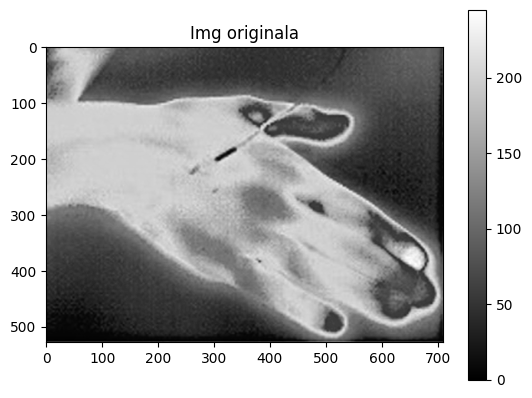

(256,)


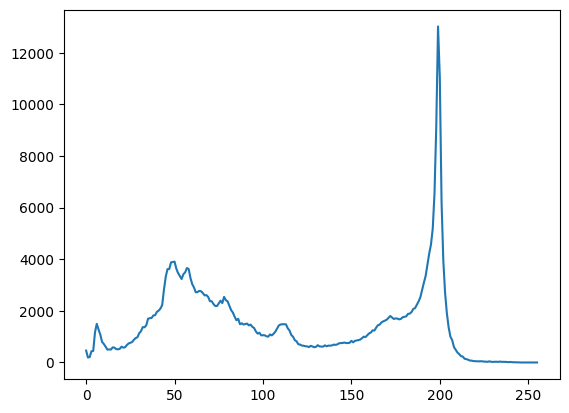

199


In [ ]:

img = io.imread('Thermogram-infrared-image-Image-of-a-hand-taken-in-mid-infrared-thermal-light (1).png')
L,C,pl = np.shape(img)

# TODO fa o "histograma" pentru diferentele dintre pixeli ca sa vezi mai bine pragul
if pl > 2:
    print("original image not grayscale \nsize was {0}".format(np.shape(img)))
    img=np.uint8(color.rgb2gray(img[:,:,:3])*255)
else:
    img = img
    print(np.shape(img))

plt.figure(), plt.title("Img originala"), plt.imshow(img, cmap='gray'),plt.colorbar(),plt.show()

hhfloat, _ = np.histogram(img, bins=256, range=(0, 256), density=False)
print(np.shape(hhfloat))
plt.figure(), plt.plot(hhfloat), plt.show()
print(np.argmax(hhfloat))